In [26]:
from PIL import ImageGrab

def maak_screenshot(bbox):
    """
    Maakt een screenshot van een opgegeven gebied op het scherm.

    Args:
        bbox (tuple): Een tuple van (left, top, right, bottom) coördinaten van het gebied.

    Returns:
        PIL.Image.Image: Een Pillow Image object van de screenshot.
    """
    screenshot = ImageGrab.grab(bbox=bbox)
    return screenshot

spelbord_bbox = (0,0,1300,1000) # Voorbeeld coördinaten, aanpassen aan jouw situatie
screenshot_pil_image  = maak_screenshot(spelbord_bbox)

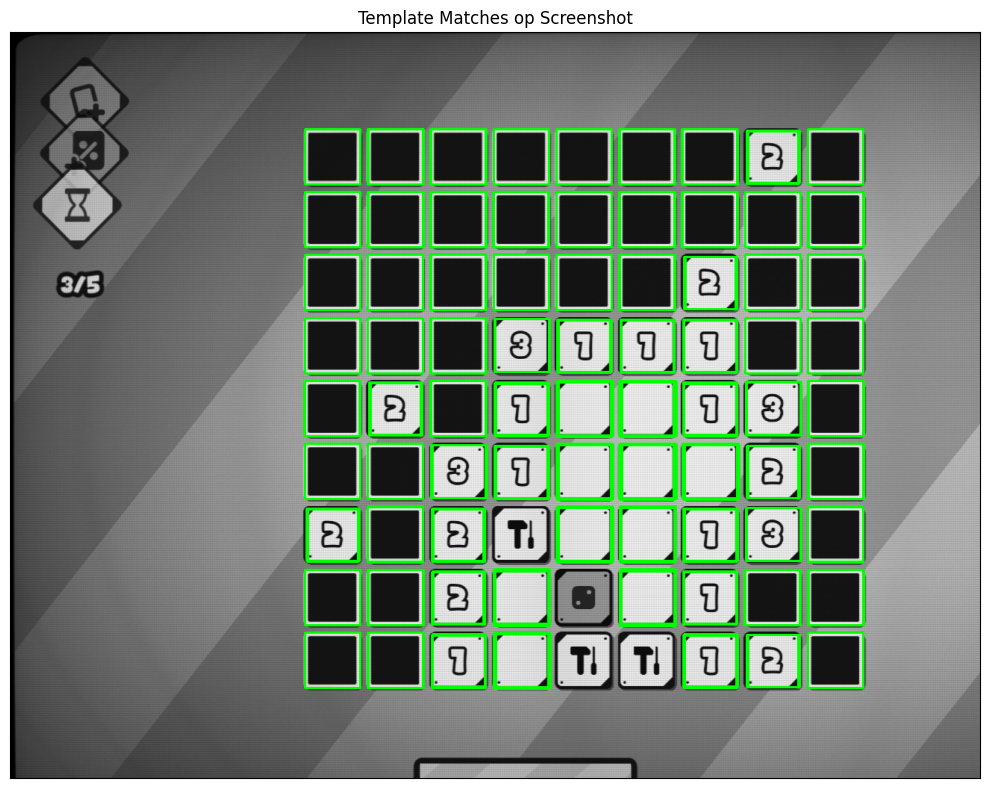

Template matches gevisualiseerd met bounding boxes op de screenshot.
Lijst van gevonden templates is aangemaakt: gevonden_templates_lijst
min_x: 394, max_x: 1070, min_y: 131, max_y: 809
Template breedte: 85.2, Template hoogte: 84.0
Aantal kolommen: 9, Aantal rijen: 9

Matrix representatie van het Minesweeper bord:
K     K     K     K     K     K     K     2     K    
K     K     K     K     K     K     K     K     K    
K     K     K     K     K     K     2     K     K    
K     K     K     3     1     1     1     K     K    
K     2     K     1     0     0     1     3     K    
K     K     3     1     0     0     0     2     K    
2     K     2     leeg  0     0     1     3     K    
K     K     2     0     leeg  0     1     K     K    
K     K     1     0     leeg  leeg  1     2     K    

Matrix representatie is aangemaakt: matrix_representatie


In [27]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

template_map = {
    '1': cv2.imread('Template/1.png', cv2.IMREAD_GRAYSCALE),
    '2': cv2.imread('Template/2.png', cv2.IMREAD_GRAYSCALE),
    '3': cv2.imread('Template/3.png', cv2.IMREAD_GRAYSCALE),
    '4': cv2.imread('Template/4.png', cv2.IMREAD_GRAYSCALE),
    '-1': cv2.imread('Template/bom.png', cv2.IMREAD_GRAYSCALE),
    'F': cv2.imread('Template/flag.png', cv2.IMREAD_GRAYSCALE),
    '0': cv2.imread('Template/0.png', cv2.IMREAD_GRAYSCALE),
    'K': cv2.imread('Template/leeg_niet_geklikt.png', cv2.IMREAD_GRAYSCALE),
    #'dbom': cv2.imread('Template/dooraichtig_bom.png', cv2.IMREAD_GRAYSCALE), 

}

#screenshot_cv = cv2.imread('img.png', cv2.IMREAD_GRAYSCALE)
#screenshot_cv_color = cv2.cvtColor(screenshot_cv, cv2.COLOR_GRAY2BGR)

screenshot_numpy_array = np.array(screenshot_pil_image) # Zet PIL Image om naar NumPy array
screenshot_cv = cv2.cvtColor(screenshot_numpy_array, cv2.COLOR_RGB2GRAY) # Zet NumPy array om naar grijstinten
screenshot_cv_color = cv2.cvtColor(screenshot_cv, cv2.COLOR_GRAY2BGR) # Maak een kleur afbeelding van de grijswaarde screenshot voor visualisatie


threshold = 0.038
gevonden_templates_lijst = []

for naam, template in template_map.items():
    if template is not None:
        w, h = template.shape[::-1]
        resultaat = cv2.matchTemplate(screenshot_cv, template, cv2.TM_SQDIFF_NORMED)
        # Bij SQDIFF_NORMED moet je de LOCATIES vinden waar het RESULTAAT *lager* is dan de threshold:
        locaties = np.where(resultaat <= threshold) # Let op de '<=' in plaats van '>='


        for pt in zip(*locaties[::-1]):
            cv2.rectangle(screenshot_cv_color, pt, (pt[0] + w, pt[1] + h), (0, 255, 0), 2)
            gevonden_templates_lijst.append({'naam': naam, 'locatie': pt})

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(screenshot_cv_color, cv2.COLOR_BGR2RGB))
plt.title('Template Matches op Screenshot')
plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()

print("Template matches gevisualiseerd met bounding boxes op de screenshot.")
print("Lijst van gevonden templates is aangemaakt: gevonden_templates_lijst")
#print("De lijst ziet er als volgt uit:")
#print(gevonden_templates_lijst)


# -------------------- Functie om matrix representatie te maken --------------------
def maak_matrix_representatie(gevonden_templates_lijst):
    global template_hoogte
    global template_breedte
    """
    Maakt een matrix representatie van het Minesweeper bord op basis van de lijst met gevonden templates.

    Args:
        gevonden_templates_lijst: Een lijst van dictionaries, waarbij elke dictionary
                                 de 'naam' van de template en 'locatie' (tuple) bevat.

    Returns:
        Een 2D numpy array (matrix) die het Minesweeper bord representeert.
    """
    if not gevonden_templates_lijst:
        return np.array([[]])  # Retourneer een lege matrix als de lijst leeg is

    # 1. Bepaal afmetingen (we gaan er hier even vanuit dat de templates netjes in een grid staan)
    global min_x
    global max_x
    global min_y
    global max_y
    
    min_x = min(item['locatie'][0] for item in gevonden_templates_lijst)
    max_x = max(item['locatie'][0] for item in gevonden_templates_lijst)
    min_y = min(item['locatie'][1] for item in gevonden_templates_lijst)
    max_y = max(item['locatie'][1] for item in gevonden_templates_lijst)


    # Aanname: templates zijn ongeveer even groot, gebruik de grootte van de eerste template om de stapgrootte te schatten
    voorbeeld_template_naam = gevonden_templates_lijst[0]['naam']
    template_hoogte, template_breedte = template_map[voorbeeld_template_naam].shape
    
    template_hoogte=template_hoogte*1.2
    template_breedte=template_breedte*1.2
    
    aantal_kolommen = round((max_x - min_x + template_breedte) / template_breedte)
    aantal_rijen = round((max_y - min_y + template_hoogte) / template_hoogte)

    print(f"min_x: {min_x}, max_x: {max_x}, min_y: {min_y}, max_y: {max_y}") # Print min/max coordinaten
    print(f"Template breedte: {template_breedte}, Template hoogte: {template_hoogte}") # Print template afmetingen
    print(f"Aantal kolommen: {aantal_kolommen}, Aantal rijen: {aantal_rijen}") # Print berekende matrix afmetingen
    
    # 2. Initialiseer lege matrix met 'leeg' waarde
    matrix_bord = np.full((aantal_rijen, aantal_kolommen), 'leeg', dtype=object) # Object dtype om strings te kunnen opslaan

    # 3. Vul de matrix
    for item in gevonden_templates_lijst:
        naam = item['naam']
        locatie = item['locatie']

        kolom_index = round((locatie[0] - min_x) / template_breedte)
        rij_index = round((locatie[1] - min_y) / template_hoogte)


        # Controleer of de indices binnen de matrix vallen (belangrijk!)
        if 0 <= rij_index < aantal_rijen and 0 <= kolom_index < aantal_kolommen:
             matrix_bord[rij_index, kolom_index] = naam
        else:
            print(f"Waarschuwing: Template '{naam}' op locatie {locatie} valt buiten de matrix grenzen.")


    return matrix_bord

# -------------------- Functie om de matrix representatie te printen (optioneel) --------------------
def print_matrix_representatie(matrix_bord):
    """Print de matrix representatie van het Minesweeper bord op een leesbare manier."""
    if matrix_bord.size == 0: # Check for empty matrix
        print("De matrix representatie is leeg.")
        return

    for rij in matrix_bord:
        print(' '.join(str(cel).ljust(5) for cel in rij)) # `ljust` voor nette uitlijning

# -------------------- Gebruik de functies --------------------
matrix_representatie = maak_matrix_representatie(gevonden_templates_lijst)

print("\nMatrix representatie van het Minesweeper bord:")
print_matrix_representatie(matrix_representatie)

print("\nMatrix representatie is aangemaakt: matrix_representatie")

In [28]:
def verander_letters_in_getallen(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            if matrix[i][j] == 'F':
                matrix[i][j] = 'M'
            if matrix[i][j] == 'leeg':
                matrix[i][j] = '0'
            if matrix[i][j] == 'dbom':
                matrix[i][j] = 'M'
                
            if matrix[i][j] != 'K' and matrix[i][j] != 'S' and matrix[i][j] != 'M':
                matrix[i][j] = int(matrix[i][j])
    return matrix
letter_goed_matrix = verander_letters_in_getallen(matrix_representatie.copy())
print_matrix_representatie(letter_goed_matrix)

K     K     K     K     K     K     K     2     K    
K     K     K     K     K     K     K     K     K    
K     K     K     K     K     K     2     K     K    
K     K     K     3     1     1     1     K     K    
K     2     K     1     0     0     1     3     K    
K     K     3     1     0     0     0     2     K    
2     K     2     0     0     0     1     3     K    
K     K     2     0     0     0     1     K     K    
K     K     1     0     0     0     1     2     K    


In [29]:
from itertools import product

def get_neighbors(board, row, col):
    """Geeft de lijst van aangrenzende cellen (inclusief diagonaal) voor (row, col)."""
    neighbors = []
    rows = len(board)
    cols = len(board[0])
    for r in range(max(0, row - 1), min(rows, row + 2)):
        for c in range(max(0, col - 1), min(cols, col + 2)):
            if r == row and c == col:
                continue
            neighbors.append((r, c))
    return neighbors

def get_border_cells(board):
    """
    Verzamelt alle cellen met de waarde "K" die grenzen aan een onthulde cijfercel.
    Dit zijn de cellen waarvoor we constraints kunnen opstellen.
    """
    border_cells = set()
    for i in range(len(board)):
        for j in range(len(board[0])):
            if str(board[i][j]).isdigit():
                for (r, c) in get_neighbors(board, i, j):
                    if board[r][c] == "K":
                        border_cells.add((r, c))
    return list(border_cells)

def get_constraints(board, border_cells):
    """
    Voor elke cijfercel: bepaal het aantal bommen dat in de aangrenzende frontier-cellen
    moet staan. Constraint wordt opgeslagen als: (positie, bom_count, lijst onbekende cellen).
    """
    constraints = []
    for i in range(len(board)):
        for j in range(len(board[0])):
            if str(board[i][j]).isdigit():
                num = int(board[i][j])
                neighbors = get_neighbors(board, i, j)
                # Houd al bekende bommen ("M") mee
                flagged = sum(1 for (r, c) in neighbors if board[r][c] == "M")
                # Alleen de onbekende cellen die tot de frontier behoren
                unknowns = [ (r, c) for (r, c) in neighbors if (r, c) in border_cells and board[r][c] == "K" ]
                if unknowns:
                    constraints.append(((i, j), num - flagged, unknowns))
    return constraints

def valid_assignment(assignment, constraints):
    """
    Controleer of een gegeven toewijzing (dict: cel -> True voor bom, False voor veilig)
    voldoet aan alle constraints.
    """
    for (_, bombs_required, unknowns) in constraints:
        count = sum(assignment[cell] for cell in unknowns)
        if count != bombs_required:
            return False
    return True

def compute_probabilities(board):
    """
    Berekent voor alle frontier-cellen (verkregen via get_border_cells) de kans dat er
    een bom staat op basis van alle geldige toewijzingen die voldoen aan de constraints.
    
    Retourneert:
      - probabilities: een dictionary { (i, j): kans }
      - valid_assignments: de lijst met alle geldige toewijzingen
    """
    border_cells = get_border_cells(board)
    constraints = get_constraints(board, border_cells)
    
    valid_assignments = []
    # Genereer alle mogelijke combinaties (True = bom, False = veilig)
    for assignment_tuple in product([False, True], repeat=len(border_cells)):
        assignment = { cell: bomb for cell, bomb in zip(border_cells, assignment_tuple) }
        if valid_assignment(assignment, constraints):
            valid_assignments.append(assignment)
    
    probabilities = {}
    for cell in border_cells:
        # Bereken hoeveel toewijzingen aangeven dat er een bom staat op deze cel
        bomb_count = sum(assignment[cell] for assignment in valid_assignments)
        # Bereken de kans als de fractie van toewijzingen waarin er een bom staat
        prob = bomb_count / len(valid_assignments) if valid_assignments else 0
        probabilities[cell] = prob
    return probabilities, valid_assignments

def create_probability_matrix(board, probabilities):
    """
    Creëert een matrix (zelfde afmetingen als board) waarin voor iedere onbekende cel ("K")
    de berekende kans (met twee decimalen) wordt weergegeven als deze cel tot de frontier behoort.
    Voor cellen die niet tot de frontier behoren, wordt "N/A" gezet.
    Andere cellen (bijv. getallen of "M") worden ongewijzigd gekopieerd.
    """
    prob_matrix = []
    for i in range(len(board)):
        row = []
        for j in range(len(board[0])):
            if board[i][j] == "K":
                if (i, j) in probabilities:
                    row.append(f"{probabilities[(i, j)]:.2f}")
                else:
                    row.append("N/A")
            else:
                row.append(str(board[i][j]))
        prob_matrix.append(row)
    return prob_matrix

In [30]:
# Bereken de kans op een bom per frontier-cel
probabilities, valid_assignments = compute_probabilities(letter_goed_matrix)

# Bouw een kansmatrix waarin de kansen in de corresponderende cellen komen te staan
prob_matrix = create_probability_matrix(letter_goed_matrix, probabilities)
prob_matrix

KeyboardInterrupt: 

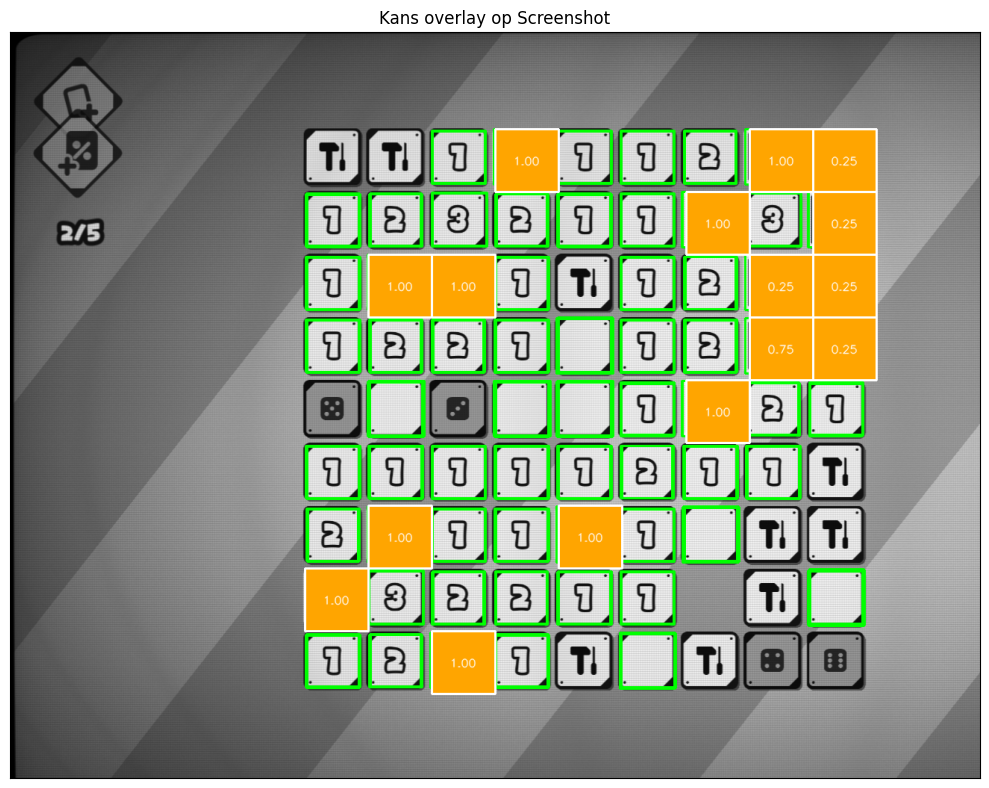

In [25]:
# Definieer de kleuren (BGR)
green  = (0, 255, 0)      # Veilig: 0 kans (groen)
red    = (0, 0, 255)      # Zeker bom: 1.00 kans (rood)
orange = (0, 165, 255)    # Onzekere kans (>0 en <1) (oranje)
white  = (255, 255, 255)  # Voor de tekst en eventueel een border

# We gaan ervan uit dat 'matrix_representatie' en 'prob_matrix' dezelfde afmetingen hebben.
rows, cols = matrix_representatie.shape

for r in range(rows):
    for c in range(cols):
        # Bepaal de positie van de cel in de screenshot (rekening houdend met de offset en de geschatte celgrootte)
        x = int(min_x + c * template_breedte)
        y = int(min_y + r * template_hoogte)
        x2 = int(x + template_breedte)
        y2 = int(y + template_hoogte)
        
        # Haal de waarden op uit de matrix en de kansmatrix
        cell_value = matrix_representatie[r, c]
        prob_value = prob_matrix[r][c]
        
        # Bepaal welke overlay we tekenen:
        # - Als de cel een bekende bom is ("M") of als de kans exact 1.00 is: rood blokje.
        # - Als de cel een frontier-cel is met kans == 0: groen blokje.
        # - Als de cel een frontier-cel is met kans tussen 0 en 1: oranje blokje met de kanswaarde.
        if cell_value == "M" or prob_value == 1.0:
            overlay_color = red
            display_text = "BOM"
        elif cell_value == "K" and prob_value != "N/A":
            prob = float(prob_value)
            if prob == 0.0:
                overlay_color = green
            else:
                overlay_color = orange
            display_text = prob_value  # Bijvoorbeeld "0.25"
        else:
            # Als er geen geldige kans is (bijvoorbeeld buiten de frontier) overslaan we deze cel.
            continue
        
        # Teken een gevuld rechthoekje over de cel
        cv2.rectangle(screenshot_cv_color, (x, y), (x2, y2), overlay_color, thickness=-1)
        
        # Teken een witte border rond het blokje voor meer zichtbaarheid
        cv2.rectangle(screenshot_cv_color, (x, y), (x2, y2), white, thickness=2)
        
        # Plaats de kanswaarde (of "BOM") in het midden van de cel
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_thickness = 1
        (text_width, text_height), baseline = cv2.getTextSize(display_text, font, font_scale, font_thickness)
        text_x = x + int((template_breedte - text_width) / 2)
        text_y = y + int((template_hoogte + text_height) / 2)
        cv2.putText(screenshot_cv_color, display_text, (text_x, text_y), font, font_scale, white, font_thickness, cv2.LINE_AA)

# Toon de screenshot met de overlay
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(screenshot_cv_color, cv2.COLOR_BGR2RGB))
plt.title('Kans overlay op Screenshot')
plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()
